### Information

#### Experimental environment

In [ ]:
a = !cat /etc/redhat-release
b = !cat /proc/cpuinfo | grep "model name"
c = !nproc
d = !free -h --total | grep Total
e = !gcc --version
# tigress_v = !docker-compose exec -t tigress obfuscate --version | grep "TIGRESS VERSION"
# ollvm_v = !docker-compose exec ollvm obfuscate --version

environment = dict(
    machine=dict(
        OS=a[0],
        CPU=b[0].split(":")[1],
        Processor_num=c[0],
        Memory=d[0].split(":")[1].split()[0]),
    tool=dict(
        gcc=dict(Version=e[0]),
        cloc=dict(Version="1.89"),
        angr=dict(Version="9.1.12332"),
        tigress=dict(Version="3.1"),
        ollvm=dict(Version="Obfuscator-LLVM clang version 4.0.1  (based on Obfuscator-LLVM 4.0.1)")
    )
)

environment

___
### Analyze

In [1]:
import json
import pathlib
import pandas as pd
import statistics
pd.options.display.float_format = '{:.4g}'.format

# Useful function
def load_test_pass_data(target: str) -> list:
    target = pathlib.Path(target).joinpath("result_test")
    data = {i.stem: [res for res in json.loads(i.read_text())]
            for i in sorted(target.glob("*.json"))}

    def all_passed(v) -> list:
        return [
            [j["fail_cause"] for j in i["compare_results"]] 
            for i in v
            if not any([j["fail_cause"] for j in i["compare_results"]])]

    def any_failed(v) -> list:
        return [
            [j["fail_cause"] for j in i["compare_results"]] 
            for i in v
            if any([j["fail_cause"] for j in i["compare_results"]])]

    return [
        dict(
            transformation_name=k,
            test_pass_rate=len(all_passed(v)) / len(v),
            passed_test_num=len(all_passed(v)),
            failed_test_num=len(any_failed(v)),
            failed_test=[i["name"] for i in v if any([j["fail_cause"] for j in i["compare_results"]])]
        ) for k, v in data.items()]


def load_exec_time_increase_rate(target: str) -> list:
    target = pathlib.Path(target).joinpath("result_test")
    data = {i.stem: [res for res in json.loads(i.read_text())]
            for i in sorted(target.glob("*.json"))}
    return [
        dict(
            transformation_name=k,
            code=[i["name"] for i in v],
            exec_time_rate=[[j["exec_time_increase_rate"] for j in i["compare_results"]] for i in v],
        ) for k, v in data.items()] 


def load_distance_data(target: str) -> list:
    target = pathlib.Path(target).joinpath("result_distance")
    data = {i.stem: [res for res in json.loads(i.read_text())]
            for i in sorted(target.glob("*.json"))}
    return [
        dict(
            transformation_name=k,
            by_3gram_Simpson=statistics.mean([x["by_3gram_simpson"] for x in v]),
            by_LCSubstr=statistics.mean([x["by_longest_common_substring"] for x in v])
        ) for k, v in data.items()]


def convert_to_dataframe(data: dict) -> pd. DataFrame:
    return pd.read_json(json.dumps(data)).set_index("transformation_name")


# Please type the name of the property to be analyzed
target_property_name = "prop1"

#### Test Pass Rate

In [ ]:
test_pass_data = load_test_pass_data(target_property_name)
df_test_pass_rate = convert_to_dataframe(test_pass_data)
# df_test_pass_rate.to_markdown()
df_test_pass_rate

##### Additional analyze

In [ ]:
# Common test failed code
failed_codes = [set(i) for i in df_test_pass_rate["failed_test"]]
common_failed_code = failed_codes[0]
for i in failed_codes[1:]:
    common_failed_code &= i
common_failed_code = sorted(common_failed_code)
print("Commonly failed codes in each transformation")
print(common_failed_code)
print()

# Unique failed code
print("Uniquely failed codes in each transformation")
for idx, v in zip(df_test_pass_rate.index, df_test_pass_rate["failed_test"]):
    unique_failed_code = sorted([i for i in v if i not in common_failed_code])
    if len(unique_failed_code) == 0:
        continue
    # print(json.dumps(dict(name=idx, unique_failed_code=unique_failed_code)))
    print(f"{idx}：{unique_failed_code}")

#### Code Distance Mean

In [ ]:
distance_data = load_distance_data(target_property_name)
df_code_distance_mean = convert_to_dataframe(distance_data)
df_code_distance_mean

___
### Plot Analyzed Data

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rc('pdf', fonttype=42)
matplotlib.rc("svg", fonttype="none")

target = ["prop1", "prop2"]

test_pass_data = sum([load_test_pass_data(t) for t in target], [])
df_test_pass_rate = convert_to_dataframe(test_pass_data)

distance_data = sum([load_distance_data(t) for t in target], [])
df_code_distance_mean = convert_to_dataframe(distance_data)

# df_test_pass_rate
# df_code_distance_mean

/tmp/ipykernel_3956954/4263185208.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["exec_time_rate"].apply(lambda x: pd.Series(x)).T.boxplot(


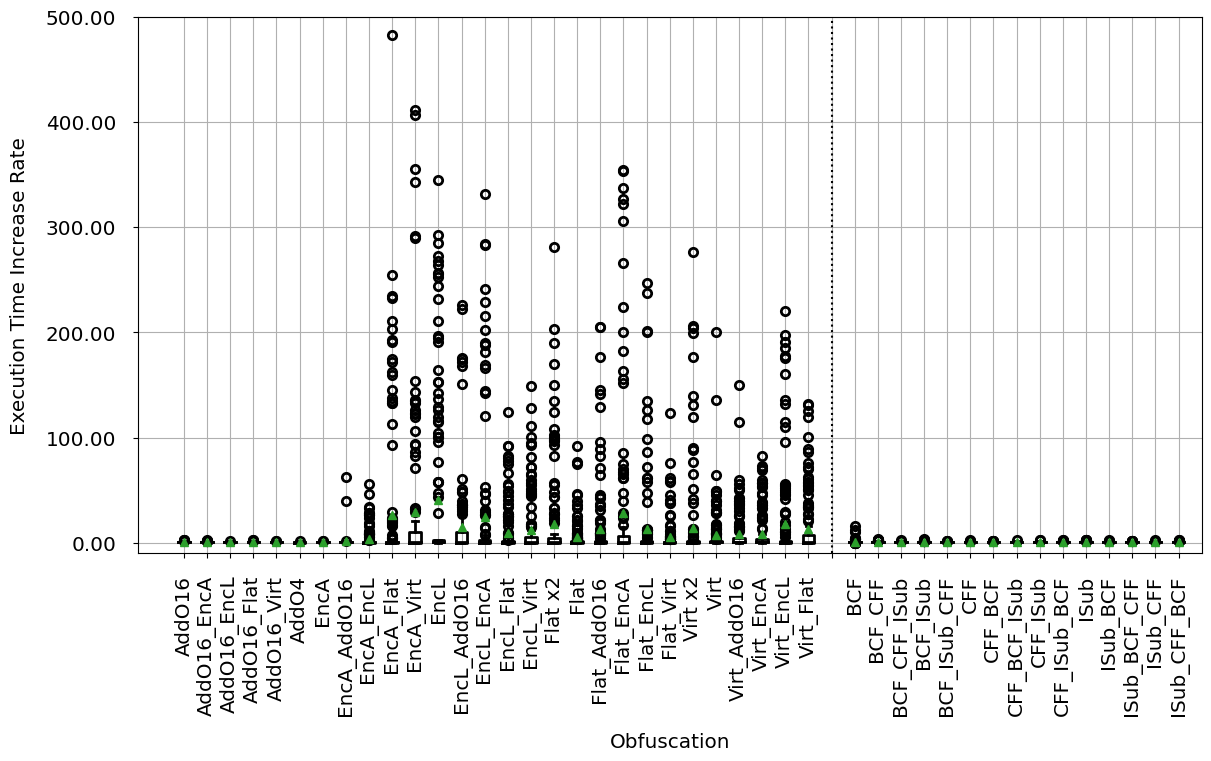

In [31]:
def plot_box_exec_time_increase_rate(df: pd.DataFrame, fname: str):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7.5), constrained_layout=True)
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    df = df.drop("code", axis=1)
    df["exec_time_rate"] = df["exec_time_rate"].apply(sum, args=([],))

    df = df.T
    df.insert(28, "", None)
    df = df.T

    df["exec_time_rate"].apply(lambda x: pd.Series(x)).T.boxplot(
        ax=ax, showmeans=True, grid=True, rot=90,
        boxprops=dict(color='black', linewidth=2),  # boxの枠線の設定
        medianprops=dict(color='black', linewidth=2),  # 中央値の線の設定
        whiskerprops=dict(color='black', linewidth=2),  # ヒゲの線の設定
        capprops=dict(color='black', linewidth=2),  # ヒゲの先端の線の設定
        flierprops=dict(markeredgecolor='black', markeredgewidth=2)  # 外れ値の設定
        )

    s = 12

    ax.set_xlabel("Obfuscation", labelpad=12, fontsize=s*1.2)
    ax.set_ylabel("Execution Time Increase Rate", labelpad=12, fontsize=s*1.2)

    ax.tick_params(axis="x", pad=12, labelsize=s*1.2)
    ax.tick_params(axis="y", pad=12, labelsize=s*1.2)

    ax.set_axisbelow(True)
    ax.set_xlim(-1, 45)
    plt.axvline(x=29, linestyle="dotted", color="k")

    ax.set_ylim(-10, 500)
    # ax.set_yticks(np.arange(0.0, 1.1, 0.2))

    # fig.savefig(f"{fname}.png")
    # plt.show()
    # plt.close("all")

exec_time_increase_rate_data = sum([load_exec_time_increase_rate(t) for t in target], [])
df_exec_time_increase_rate = convert_to_dataframe(exec_time_increase_rate_data)

# Ignore timeout code record
df = df_exec_time_increase_rate
for k, v in df.T.items():
    if k != "EncA_AddO16":
        continue
    data = dict(zip(v["code"], v["exec_time_rate"]))
    data = {k: v if k != "mergesort" else [v[0]] for k, v in data.items()}
df.at["EncA_AddO16", "exec_time_rate"] = list(data.values())
# df
plot_box_exec_time_increase_rate(df, fname="exec_time_increase_rate")

In [ ]:
def plot_code_distance_mean(df: pd.DataFrame, fname: str):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    df = df.T
    df.insert(28, "", None)
    df = df.T.reset_index()

    colors = ["#3498db", "#1abc9c", "#e74c3c"]
    markers = ["o", "s", "x"]
    [df.plot.scatter(
        ax=ax, x=df.columns[0], y=i, label=i,
        # grid=True, rot=90, color="k", marker=markers[idx], s=75)
        grid=True, rot=90, color=colors, marker=markers[idx], s=75)
     for idx, i in enumerate(df.columns[1:])]

    ax.set_axisbelow(True)
    ax.tick_params(axis="x", pad=12, labelsize=15)
    ax.tick_params(axis="y", pad=12, labelsize=15)
    ax.set_xlabel("Obfuscation Transformation", labelpad=12, fontsize=18)
    ax.set_ylabel("Code Distance Mean", labelpad=12, fontsize=18)
    ax.legend(prop=dict(size=15))
    
    ax.set_xlim(-1, 38)
    plt.axvline(x=28, linestyle="dotted", color="k")

    fig.savefig(f"{fname}.pdf")
    plt.show()
    plt.close("all")


def plot_reliability(
        df_test_pass_rate: pd.DataFrame,
        df_code_distance_mean: pd.DataFrame,
        fname: str):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    df = pd.merge(
        df_test_pass_rate,
        df_code_distance_mean,
        on="transformation_name")
    df = df.reindex(columns=["test_pass_rate", "LCSubstr", "3gram_Simpson"])
    df = df.rename(columns={
        "test_pass_rate": "Test Pass Rate",
        "3gram_Simpson": "Code Distance Mean(3-gram Simpson)",
        "LCSubstr": "Code Distance Mean(LCSubstrings)"})
    df = df.T
    df.insert(28, "", None)
    df = df.T.reset_index()

    # colors = ["#3498db", "#1abc9c", "#e74c3c"]
    markers = ["o", "+", "x"]
    [df.plot.scatter(
        ax=ax, x=df.columns[0], y=i, label=i,
        grid=True, rot=90, marker=markers[idx], s=75)
     for idx, i in enumerate(df.columns[1:])]

    ax.tick_params(axis="x", pad=12, labelsize=15)
    ax.set_xlabel("Obfuscating Transformation", labelpad=12, fontsize=18)
    ax.set_axisbelow(True)
    ax.set_xlim(-1, 38)
    ax.tick_params(axis="y", pad=12, labelsize=15)
    ax.set_ylabel("Rate", labelpad=12, fontsize=18)
    ax.set_ylim(0.0, 1.05)
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))
    ax.legend(prop=dict(size=15))

    plt.axvline(x=28, linestyle="dotted", color="k")

    fig.savefig(f"{fname}.png")
    plt.show()
    plt.close("all")

def plot_box_metrics(
        df_test_pass_rate: pd.DataFrame,
        df_code_distance_mean: pd.DataFrame,
        fname: str):
    # fig, ax = plt.subplots(1, 1, figsize=(15, 12), constrained_layout=True)
    fig, ax = plt.subplots(1, 1, figsize=(12, 7.5), constrained_layout=True)
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    df = pd.merge(
        df_test_pass_rate,
        df_code_distance_mean,
        on="transformation_name")
    df = df.reindex(columns=["test_pass_rate", "by_LCSubstr", "by_3gram_Simpson"])
    df = df.rename(columns={
        "test_pass_rate": "",
        "by_3gram_Simpson": "3-gram Simpson",
        "by_LCSubstr": "LCSubstrings"})
        # "3gram_Simpson": "Code Distance Mean\n(3-gram Simpson)",
        # "LCSubstr": "Code Distance Mean\n(LCSubstrings)"})

    df.plot.box(ax=ax, showmeans=True, grid=True,
                boxprops=dict(color='black', linewidth=2),  # boxの枠線の設定
                medianprops=dict(color='black', linewidth=2),  # 中央値の線の設定
                whiskerprops=dict(color='black', linewidth=2),  # ヒゲの線の設定
                capprops=dict(color='black', linewidth=2),  # ヒゲの先端の線の設定
                flierprops=dict(markeredgecolor='black', markeredgewidth=2)  # 外れ値の設定
    )

    s = 24
    ax.tick_params(axis="x", pad=12, labelsize=s*1.2)
    ax.set_axisbelow(True)
    ax.text(1.0, -0.175, "Test Pass Rate", size=s*1.2,
        horizontalalignment="center",
        verticalalignment="center")
    ax.text(2.5, -0.175, "Code Distance Mean", size=s*1.2,
        horizontalalignment="center",
        verticalalignment="center")
    # ax.set_xlim(0.5, 4.5)
    ax.tick_params(axis="y", pad=12, labelsize=s*1.2)
    ax.set_ylabel("Rate", labelpad=12, fontsize=s*1.2)
    ax.set_ylim(0.0, 1.05)
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))

    fig.savefig(f"{fname}.png")
    plt.show()
    plt.close("all")


# plot_reliability(df_test_pass_rate[["test_pass_rate"]],
                #  df_code_distance_mean, fname="exp_result_color")
# plot_box_metrics(df_test_pass_rate[["test_pass_rate"]],
                #  df_code_distance_mean, fname="exp_result_box")
# plot_code_distance_mean(df_code_distance_mean, fname="exp_code_distance_mean")
